# Train a CNN model for end-to-end learning 

In [1]:
# load libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import matplotlib.image as mpimg

# 1. Data wrangling

## 1.1 Read log file

In [2]:
# read data log
file_path = "/Users/daruizhang/Documents/Data/driving_log.csv"

#drive_log = pd.read_csv(file_path,header=None)
drive_log = pd.read_csv(file_path)

# peek the content
drive_log.head()

print(drive_log.shape)

(8036, 7)


## 1.2 Get steering angle (Y)

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64


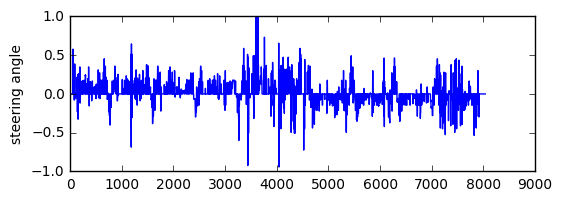

In [3]:
# select the steering angle
Y = drive_log['steering']

# peek the data
print(Y.describe())

# plot steering angle
plt.figure(figsize=(6, 2))
plt.plot(Y)
plt.ylabel('steering angle')


## 1.3 Get image directory

In [4]:
# image directory
img_dir = drive_log['center']

# peek the directory
img_dir.head()

0    IMG/center_2016_12_01_13_30_48_287.jpg
1    IMG/center_2016_12_01_13_30_48_404.jpg
2    IMG/center_2016_12_01_13_31_12_937.jpg
3    IMG/center_2016_12_01_13_31_13_037.jpg
4    IMG/center_2016_12_01_13_31_13_177.jpg
Name: center, dtype: object

## 1.4 Get image data

In [5]:
# load a image file given an image directory
def load_img(img_dir):
    img_dir = '/Users/daruizhang/Documents/Data/'+ img_dir
    img = mpimg.imread(img_dir)
    return img

IMG/center_2016_12_01_13_30_48_404.jpg
(160, 320, 3)
<class 'numpy.ndarray'>


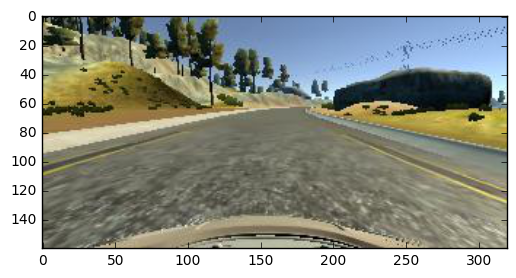

In [6]:
# Test the function
img1 = load_img(img_dir[2000])

plt.imshow(img1) # plot image
print(img_dir[1])
print(img1.shape)
print(type(img1))

# 1.5 Preprocess image (grayscale, resize)

In [9]:
def process_img(img):
    # convert to grayscale    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # select area of interst
    img = img[60:140, 0:320]
    print(img.shape)
    
    # reduce size
    img = cv2.resize(img, (160, 40)) 
    
    # debug
    print(img.shape)
    plt.imshow(img)

    # add one more dimension
    img  = np.reshape(img,[40, 160,1]) 

    return img

(80, 320)
(40, 160)
(40, 160, 1)


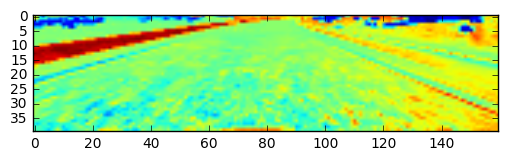

In [10]:
# Test the function
img2 = process_img(img1)
print(img2.shape)

# 1.6 Stack all images (X)

### Inicialize

In [11]:
# inicialize
n_img = len(img_dir) # number of the image
# inicialize X
X = np.empty((n_img,40,160,1))

print(X.shape)

(8036, 40, 160, 1)


In [12]:
# stack the image to make X
def stack_img(img_dir,n_img): # input directory, and image
    for n in range(n_img):
        img = load_img(img_dir[n]) # load color image
        img = process_img(img) # grey and small
        #img  = np.reshape(img,[16, 32,1]) # add one dimension
        #img  = np.reshape(img,[40, 160,1]) # add one dimension

        X[n,:]=img
        return X

(80, 320)
(40, 160)
(8036, 40, 160, 1)


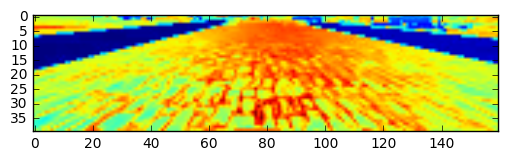

In [13]:
X = stack_img(img_dir,n_img)
print(X.shape)

(40, 160, 1)
(40, 160)


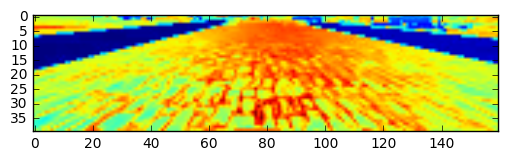

In [15]:
# Test if the funciton is corect
img = X[0,:,:]
print(img.shape)
#img  = np.reshape(img,[16, 32]) # reshape
img  = np.reshape(img,[40, 160]) # reshape

print(img.shape)
plt.imshow(img)# show image

# save X and Y

In [16]:
#Binary data
#np.save('X.npy', X)
#np.save('Y.npy', Y)

# 2. CNN model 

In [26]:
# load library
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop


In [17]:
# input shape
input_shape = X.shape[1:]
print(input_shape, 'input shape')

(40, 160, 1) input shape


In [22]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)


Train size: (6428, 40, 160, 1)
Test size: (1608, 40, 160, 1)


## 2.1 define CNN

In [24]:
# Initiating the model

model = Sequential()

model.add(Convolution2D(24, 4, 4,input_shape = input_shape, name='cn1'))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Convolution2D(8, 4, 4,input_shape = input_shape,name='cn2'))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Flatten(name='flatten'))

model.add(Dense(10, name='fc1'))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(2, name='fc2'))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1, name='fc3'))


# Print out summary of the model
model.summary()

# Compile model using Adam optimizer 
model.compile(loss='mean_squared_error',
              optimizer=Adam())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cn1 (Convolution2D)              (None, 37, 157, 24)   408         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 37, 157, 24)   0           cn1[0][0]                        
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 37, 157, 24)   0           activation_5[0][0]               
____________________________________________________________________________________________________
cn2 (Convolution2D)              (None, 34, 154, 8)    3080        dropout_5[0][0]                  
___________________________________________________________________________________________

## 2.2 Train model

In [25]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, nb_epoch= 5, 
                    verbose=1, callbacks=[], validation_split=0.3, 
                    validation_data=None, shuffle=True, 
                    class_weight=None, sample_weight=None)


Train on 4499 samples, validate on 1929 samples
Epoch 1/5
4499/4499 [==============================] - 105s - loss: 0.0180 - val_loss: 0.0165
Epoch 2/5
4499/4499 [==============================] - 96s - loss: 0.0173 - val_loss: 0.0164
Epoch 3/5
4499/4499 [==============================] - 89s - loss: 0.0173 - val_loss: 0.0164
Epoch 4/5
4499/4499 [==============================] - 97s - loss: 0.0173 - val_loss: 0.0165
Epoch 5/5
4499/4499 [==============================] - 101s - loss: 0.0173 - val_loss: 0.0164


# 2.3 Test model performance

## Test on the test set

Test on the test set:
std: 0.121606732407
mean: 0.00351953322886
1608/1608 [==============================] - 18s    
pred_test: [[ 0.00596835]
 [ 0.00596835]
 [ 0.00596835]
 ..., 
 [ 0.00596835]
 [ 0.00596835]
 [ 0.00596835]]


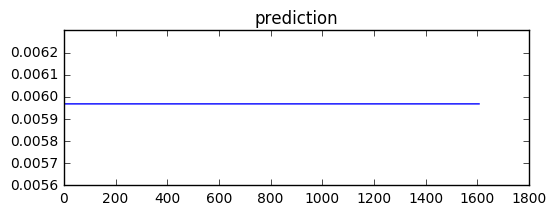

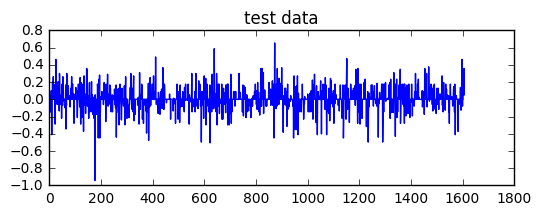

In [36]:
# test statis
print("Test on the test set:")
print('std:', y_test.std())
print('mean:', y_test.mean())

# test results 
pred_test = model.predict(
                    x = X_test,
                    batch_size=1,
                    verbose=1)

# plot test set
plt.figure(1)  
plt.figure(figsize=(6, 2))
plt.title('prediction')
plt.plot(pred_test)

plt.figure(2)  
plt.figure(figsize=(6, 2))
plt.title('test data')
plt.plot(np.asarray(y_test))


print('pred_test:',pred_test)

## Test on the traing set

Test on the training set:
std: 0.130595614931
mean: 0.00420725735423
6428/6428 [==============================] - 66s    
pred_train: [[ 0.00596835]
 [ 0.00596835]
 [ 0.00596835]
 ..., 
 [ 0.00596835]
 [ 0.00596835]
 [ 0.00596835]]


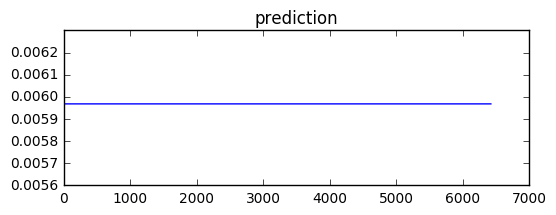

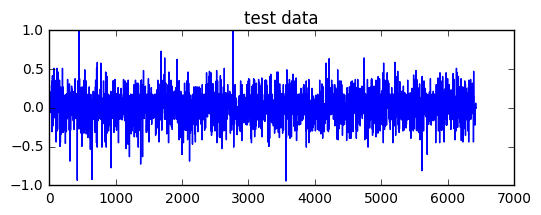

In [38]:
# training statistic
print("Test on the training set:")
print("std:",y_train.std())
print("mean:",y_train.mean())


# trainging results
pred_train = model.predict(
                    x = X_train,
                    batch_size=1,
                    verbose=1)

# plot test set
plt.figure(1)  
plt.figure(figsize=(6, 2))
plt.title('prediction')
plt.plot(pred_train)

plt.figure(2)  
plt.figure(figsize=(6, 2))
plt.title('test data')
plt.plot(np.asarray(y_train))



print('pred_train:',pred_train)

# 2.3 Save weights and model

In [179]:
# load library
import json
import h5py

In [180]:
# Save model as json file
json_string = model.to_json()

# save weights
with open('model.json', 'w') as outfile:
        json.dump(json_string, outfile)

        # save weights
        model.save_weights('./model.h5')
        print("Model saved")

Saved
